# NLP 2025
# Lab 4: Prompting Large Language Models

LLMs are everywhere nowadays. You have probably used their many times and have seen their results. You might have seen good and bad results and that often how you ask the model to do something makes a big difference.
In this lab we will have a closer look at the prompting of LLMs. While often you would need to fine-tune the model for a specific task, you will see that prompting can be a powerful tool to shape the models responses.

An important distinction between this and the previous labs is that you will have to prepare a video presentation instead of the usual report. You will find more information in the notebook.

By the end of this lab you should be able to:
- Load a pre-trained LLM
- Use the LLM to generate text
- Experiment with different prompting strategies
- Use the LLM to generate text based on the dataset
- Evaluate the generated text



### Exercises

In this lab the exercises are not graded. We will only grade the final video presentation. You can find the instructions in the last exercise ([Exercise 6](#e6)). The other exercises are there to guide you, and you should complete them as well, but they are not graded directly. However, keep in mind that the content you present on the video should correspond to findings of your notebook.

| Exercise            |
|---------------------|
| [Exercise 1](#e1)   |
| [Exercise 2](#e2)   |
| [Exercise 3](#e3)   |
| [Exercise 4](#e4)   |
| [Exercise 5](#e5)   |
| [Exercise 6](#e6)   |

The maximum grade for this lab is 0.5 points.

### 📌 **Instructions for Delivery** (📅 **Deadline: 12/May 18:00**, 🎭 *wildcards possible*)

✅ **Submission Requirements**
+ 📄 You need to submit a **video presentation** that is no longer than 5 minutes and a **copy of your notebook** 📓 with the code.
+ ⚡ Make sure that **all cells are executed properly** ⚙️ and that **all figures/results/plots** 📊 you include in the presentation are also visible in your **executed notebook**.

✅ **Collaboration & Integrity**
+ 🗣️ While you may **discuss** the lab with others, you must **write your solutions with your group only**. If you **discuss specific tasks** with others, please **include their names** in the appendix of the report.
+ 📜 **Honor Code applies** to this lab. For more details, check **Syllabus §7.2** ⚖️.
+ 📢 **Mandatory Disclosure**:
   - Any **websites** 🌐 (e.g., **Stack Overflow** 💡) or **other resources** used must be **listed and disclosed**.
   - Any **GenAI tools** 🤖 (e.g., **ChatGPT**) used must be **explicitly mentioned**.
   - 🚨 **Failure to disclose these resources is a violation of academic integrity**. See **Syllabus §7.3** for details.

Collaborators: list collaborators here

**I talked with Jerry about...**

Use of genAI tools (e.g. chatGPT), websites (e.g. stackoverflow): list websites where you found code (or other info) as well as include information on how you used genAI tools (e.g. prompts):

I asked chatGPT about...

## 0. Setup
We start by making sure we have everything we need for this lab.


### 0.1 Using Google Colab

In this lab we will be generating text using LLMs. While we choose the small models for the exercises, they are still quite large and require a lot of memory. We recommend using google colab for this lab but you can also run it on your local machine if you have a GPU.

As mentioned before, Google Colab [https://colab.google/](https://colab.google/) gives you access to a GPU for a limited time (after you used this time you will have to wait for some time to use it again). To use a GPU you need to select the runtime type. Go to "Runtime -> Change runtime type". There you can select a CPU or a GPU.

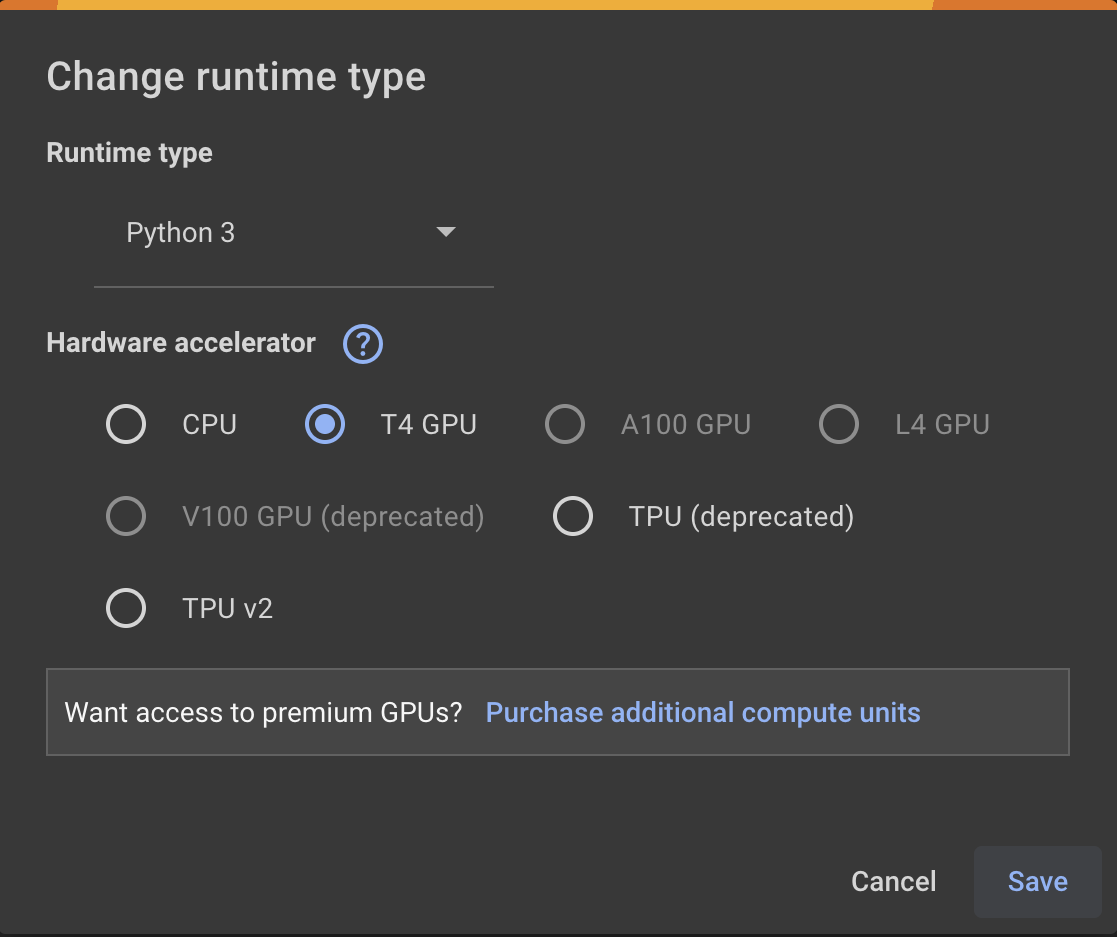

### 0.2 Installs and Imports

The following cell installs the required packages. You can run it if you are using Google Colab or if you are missing any of the packages. If you are using a local environment, you can copy the commands and run them in your terminal.

In [1]:
! pip install -U datasets
! pip install torch torchvision torchaudio
! pip install transformers
! pip install accelerate
! pip install sacrebleu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [2]:
! pip list | grep -E 'torch|transformers|datasets|accelerate'

accelerate                            1.6.0
datasets                              3.6.0
sentence-transformers                 3.4.1
tensorflow-datasets                   4.9.8
torch                                 2.6.0+cu124
torchaudio                            2.6.0+cu124
torchsummary                          1.5.1
torchvision                           0.21.0+cu124
transformers                          4.51.3
vega-datasets                         0.9.0


As usual, we start by importing some essential Python libraries that we will be using.

In [3]:
import math

import numpy as np
import matplotlib.pyplot as plt
import datasets
import transformers
import tqdm
import torch
import sacrebleu
import random

In [4]:
SEED_VALUE = 505


random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

## 1. Load and Preprocess Data

For easiness and comparison purposes, we will ue the same dataset as in the previous two labs. That said, this time we will not use it for the task of information retrieval but for *sentence compression*. We will be using LLMs to generate the compressed sentences.

As a reminder:

*Sentence compression* involves rephrasing sentences to make them shorter while still retaining the original meaning. A reliable compression system would be valuable for mobile devices and could also serve as a component in an extractive summarization system.

The dataset we are going to use can be found on [Huggingface](https://huggingface.co/datasets/embedding-data/sentence-compression). It concerns a set of 180,000 pairs of sentences, aka it is a parallel corpus of sentences and their equivalent compressions. It has been collected by harvesting news articles from the Internet where the headline appears to be similar to the first sentence and that property is used to find an "extractive" compression of the sentence.

For example, for the sentence

`"Regulators Friday shut down a small Florida bank, bringing to 119 the number of US bank failures this year amid mounting loan defaults"`

the compressed equivalent (based on the dataset) is:

`"Regulators shut down small Florida bank"`.


For more information you can read the original paper (from Google) [here](https://aclanthology.org/D13-1155.pdf). If you haven't done so for Lab 2, we strongly recommend going over the paper to gain further insights

### 1.1 Loading the Dataset

The dataset will be loaded as a huggingface dataset. This may take a few minutes because of the large size of the data.

Make sure to inspect the dataset and make sure it is imported properly.

In [5]:
ds = datasets.load_dataset('embedding-data/sentence-compression')
print(ds)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.88k [00:00<?, ?B/s]

sentence-compression_compressed.jsonl.gz:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/180000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['set'],
        num_rows: 180000
    })
})


In [6]:
for i in range(10):
    print(ds['train'][i])

{'set': ["The USHL completed an expansion draft on Monday as 10 players who were on the rosters of USHL teams during the 2009-10 season were selected by the League's two newest entries, the Muskegon Lumberjacks and Dubuque Fighting Saints.", 'USHL completes expansion draft']}
{'set': ['Major League Baseball Commissioner Bud Selig will be speaking at St. Norbert College next month.', 'Bud Selig to speak at St. Norbert College']}
{'set': ["It's fresh cherry time in Michigan and the best time to enjoy this delicious and nutritious fruit.", "It's cherry time"]}
{'set': ['An Evesham man is facing charges in Pennsylvania after he allegedly dragged his girlfriend from the side of his pickup truck on the campus of Kutztown University in the early morning hours of Dec. 5, police said.', 'Evesham man faces charges for Pa.']}
{'set': ["NRT LLC, one of the nation's largest residential real estate brokerage companies, announced several executive appointments within its Coldwell Banker Residential B

The dataset comes with a `train` split, so we will have to split that into `train`/`test` ourselves with the line below. This time we will choose a very small test subset. This is to reduce the execution time of the lab as LLMs can take quite a long time to generate text as it is generated one token after another. In a real-world scenario, you would want to have a larger test set (e.g. 10% of the dataset).

In [7]:
split_ds = ds['train'].train_test_split(test_size=1000, seed=1)
print(split_ds)

DatasetDict({
    train: Dataset({
        features: ['set'],
        num_rows: 179000
    })
    test: Dataset({
        features: ['set'],
        num_rows: 1000
    })
})


As in previous lab, we will be using the pre-trained tokenizer, so we will omit the cleaning process. You can still add it if you want more control over the data.

<a name='e1'></a>
### Exercise 1

Fill in the function below to unpack the `sentence` and `compressed` fields. You can copy it from the previous lab.

In [8]:
def unpack(examples):
    """
    Unpacks the column `set` into two columns `sentence` and `compressed`.
    Args:
        examples: a batch of examples from the dataset

    Returns: modified examples with two new columns: `sentence` and `compressed`

    """
    sentences = []
    compressed_sentences = []

    ### YOUR CODE HERE

    for n in examples["set"]:
        sentences.append(n[0])
        compressed_sentences.append(n[1])

    ### YOUR CODE ENDS HERE

    examples['sentence'] = sentences
    examples['compressed'] = compressed_sentences
    return examples

In the next cell, we will apply the `unpack` function to the whole dataset. Notice that we also drop the original `set` column.

In [9]:
split_ds = split_ds.map(unpack, batched=True, remove_columns=['set'])
print(split_ds)

for i in range(10):
    print(split_ds['train'][i])

Map:   0%|          | 0/179000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'compressed'],
        num_rows: 179000
    })
    test: Dataset({
        features: ['sentence', 'compressed'],
        num_rows: 1000
    })
})
{'sentence': 'City officials have announced the annual Taste of Chicago festival will add food trucks during concerts for the first time.', 'compressed': 'Taste of Chicago to add food trucks for concerts'}
{'sentence': 'Los Angeles Lakers centre Andrew Bynum might need more surgery on his injured left knee.', 'compressed': "Lakers' Andrew Bynum may need more surgery"}
{'sentence': 'Ellen DeGeneres is the new face of CoverGirl, the comedienne announced on her talk show on Tuesday.', 'compressed': 'Ellen DeGeneres is the new face of CoverGirl.'}
{'sentence': "Amazon.com Inc. unveiled a larger, high-speed Kindle Fire tablet on Thursday for US$499, challenging Apple Inc's dominant iPad and intensifying a battle with Google Inc and Microsoft in the booming tablet arena.", 'compresse

In this lab, we will be using only pre-trained models. That means that we won't be training any new model. This is the reason we can select only the `test` subset for the rest of the notebook (this is where we will be assessing the performance of the pre-trained models). Do not delete the training subset as you will need it for the few-shot learning exercise.

In [10]:
test_ds = split_ds['test']
print(test_ds)

Dataset({
    features: ['sentence', 'compressed'],
    num_rows: 1000
})


### 1.2 Loading the Tokenizer

For the first part of this lab, we will be using a pre-trained LLM. We will be using the [Qwen2.5-0.5B-Instruct](https://huggingface.co/Qwen/Qwen2.5-0.5B-Instruct) model from Alibaba Cloud. The model has been instruction-tuned (hence the "Instruct" in the name). It is very small with 0.5B parameters, but it should be enough for this lab. The paper is available [here](https://arxiv.org/abs/2407.10671).

We will specify the model name that can be found on the model's card on huggingface (revisit the first link). Make sure to check what other information Huggingface is offering (e.g. how to use the model, limitations, how to inference, etc.).

In [11]:
model_name = "Qwen/Qwen2.5-0.5B-Instruct"

The models on huggingface come with their own tokenizers. They are loaded separately from the models. We can use [AutoTokenizer](https://huggingface.co/docs/transformers/v4.40.2/en/model_doc/auto#transformers.AutoTokenizer)'s `from_pretrained()` method to load it.

Inspect the output: The loaded object is of `Qwen2TokenizerFast` class.

In [12]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
print(tokenizer)

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Qwen2TokenizerFast(name_or_path='Qwen/Qwen2.5-0.5B-Instruct', vocab_size=151643, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|im_end|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>', '<|object_ref_start|>', '<|object_ref_end|>', '<|box_start|>', '<|box_end|>', '<|quad_start|>', '<|quad_end|>', '<|vision_start|>', '<|vision_end|>', '<|vision_pad|>', '<|image_pad|>', '<|video_pad|>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151646: AddedToken("<|object_ref_start|>", rstrip=False, lstrip=False, single_word=False,

Next, let's see how we can use it to tokenize some text.

In [13]:
print(test_ds[0]['sentence'])
tokenized = tokenizer(test_ds[0]['sentence'], padding=True, return_tensors='pt')
print("---")
print(type(tokenized))
print("---")
print(tokenized)

GlobalFoundries Inc. is challenging the $160 million assessment that the town of Malta has tentatively placed on its property at the Luther Forest Technology Campus in Malta.
---
<class 'transformers.tokenization_utils_base.BatchEncoding'>
---
{'input_ids': tensor([[11646,  6650,  4019,  4848,    13,   374, 17003,   279,   400,    16,
            21,    15,  3526, 15449,   429,   279,  6290,   315, 60650,   702,
         15632,  7887,  9099,   389,  1181,  3343,   518,   279, 35202, 19988,
         11791, 38580,   304, 60650,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


Examine the outputs: This is very similar to the output of the `tokenizer` function from the previous lab. This time we have two fields:
- `input_ids` - this is a PyTorch tensor with the indices of our tokens.
- `attention_mask` - holds the mask that the model will use to determine if the tokens in the `input_ids` are the real tokens or *padding*.

Let's detokenize the output of the tokenizer and inspect the outputs.

In [14]:
print(tokenized['input_ids'].shape)
print("---")
print(tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0]))
print("---")
print(len(tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0])))
print("---")
print(tokenizer.decode(tokenized['input_ids'][0]))
print("---")
print(tokenizer.decode(tokenized['input_ids'][0], skip_special_tokens=True))

torch.Size([1, 35])
---
['Global', 'Found', 'ries', 'ĠInc', '.', 'Ġis', 'Ġchallenging', 'Ġthe', 'Ġ$', '1', '6', '0', 'Ġmillion', 'Ġassessment', 'Ġthat', 'Ġthe', 'Ġtown', 'Ġof', 'ĠMalta', 'Ġhas', 'Ġtent', 'atively', 'Ġplaced', 'Ġon', 'Ġits', 'Ġproperty', 'Ġat', 'Ġthe', 'ĠLuther', 'ĠForest', 'ĠTechnology', 'ĠCampus', 'Ġin', 'ĠMalta', '.']
---
35
---
GlobalFoundries Inc. is challenging the $160 million assessment that the town of Malta has tentatively placed on its property at the Luther Forest Technology Campus in Malta.
---
GlobalFoundries Inc. is challenging the $160 million assessment that the town of Malta has tentatively placed on its property at the Luther Forest Technology Campus in Malta.


### 1.4 Loading the Model

In this section, we will load and examine the model. We will start with selecting the device we will place the model on. This will be a GPU (if one is available) or a CPU.

The following cell will select the device for us.

In [15]:
device = 'cuda:0' if torch.cuda.is_available() else 'mps'
print(f'Device: {device}')

Device: cuda:0


Now, let's load the model from huggingface and place it on the device from the previous cell (the methods `to()`).

In [16]:
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
model.to(device)
print(model)

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

What is the architecture of the model? You can take the outputs of the previous cell, check the model's card on huggingface, or read the paper linked above.

## 2. Prompting the Model

In this section we will explore some prompting techniques. Let us start with the very simple one: "Compress the following sentence: {SENTENCE-TO-BE-COMPRESSED} Compressed: ". The model should see text and start generating the desired output (the compressed sentence). We will use an example from the dataset to test it. The `max_new_tokens` parameter specifies the maximum number of tokens to generate. The model will be forced to stop generating when it reaches this number of tokens.

In [17]:
sentence = test_ds[2]['sentence']
compressed = test_ds[2]['compressed']
prompt = f"Compress the following sentence: {sentence} Compressed: "

model_inputs = tokenizer([prompt], return_tensors="pt").to(model.device)
print(tokenized)
output_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)

{'input_ids': tensor([[11646,  6650,  4019,  4848,    13,   374, 17003,   279,   400,    16,
            21,    15,  3526, 15449,   429,   279,  6290,   315, 60650,   702,
         15632,  7887,  9099,   389,  1181,  3343,   518,   279, 35202, 19988,
         11791, 38580,   304, 60650,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


Let's examine the output. output.

In [18]:
print(tokenizer.decode(output_ids[0], skip_special_tokens=False))

Compress the following sentence: ALASTAIR Cook dedicated his 10th Test ton to Graham Gooch as England dominated the South Africans yesterday. Compressed: 10th Test goal scored by last year's Test top scorer, Graham Gooch, was awarded to ALASTAIR Cook for his unbeaten century in South Africa yesterday. The match between England and South Africa concluded with England winning 3-2 on day one of the series.
The match between England and South Africa ended with England prevailing by a score of 3-2 at the end of the first day of play. Graham Gooch, who had been named the Test Top Scorer of the season, was given the 10th Test goal by ALASTAIR Cook for his outstanding performance during the match. Cook’s goal secured England's victory over the South Africans. The game was played in Durban, South Africa, where England won 3-2 after a thrilling contest that featured strong bowling from both teams. Cook scored an impressive 186 runs off 49 balls while Gooch added another 58 wickets, contributing 

You can see that our prompt is included in the output. The next cell should fix that.

In [19]:
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, output_ids)
]

We can re-examine the output. The `generated_ids` variable contains the generated tokens. We can decode them to get the generated text.

In [20]:
print(generated_ids)

generated_decoded = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print('full sentence:')
print(sentence)
print()
print('generated:')
print(generated_decoded)
print()
print('expected:')
print(compressed)
print()


[tensor([   16,    15,   339,  3393,  5795, 16548,   553,  1537,  1042,   594,
         3393,  1909, 63669,    11, 25124,   479,  2624,   331,    11,   572,
        21328,   311,  8753,  6349, 57161, 12514,   369,   806, 65571, 13518,
         9294,   304,  4882, 10174, 13671,    13,   576,  2432,  1948,  9448,
          323,  4882, 10174, 19941,   448,  9448, 10987,   220,    18,    12,
           17,   389,  1899,   825,   315,   279,  4013,   624,   785,  2432,
         1948,  9448,   323,  4882, 10174,  9482,   448,  9448, 60029,   553,
          264,  5456,   315,   220,    18,    12,    17,   518,   279,   835,
          315,   279,  1156,  1899,   315,  1486,    13, 25124,   479,  2624,
          331,    11,   879,  1030,  1012,  6941,   279,  3393,  6909,  2463,
        14827,   315,   279,  3200,    11,   572,  2661,   279,   220,    16,
           15,   339,  3393,  5795,   553,  8753,  6349, 57161, 12514,   369,
          806, 18781,  5068,  2337,   279,  2432,    13, 12514,

The response of the model is probably not great. This is because it has been trained as a chat-bot and it requires a certain structure of the conversation. Below the same prompt is passed to the chat template with a system prompt `You are Qwen, created by Alibaba Cloud. You are a helpful assistant.`. It is included in the `messages` list below. Let us see the result for the same prompt.

In [21]:
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

print(text)

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
Compress the following sentence: ALASTAIR Cook dedicated his 10th Test ton to Graham Gooch as England dominated the South Africans yesterday. Compressed: <|im_end|>
<|im_start|>assistant



We can try this out using the next cell.

In [22]:
sentence = test_ds[2]['sentence']
compressed = test_ds[2]['compressed']
prompt = f"Compress the following sentence: {sentence} Compressed: "

messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

output_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, output_ids)
]

generated_decoded = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

print('full sentence:')
print(sentence)
print()
print('generated:')
print(generated_decoded)
print()
print('expected:')
print(compressed)
print()

full sentence:
ALASTAIR Cook dedicated his 10th Test ton to Graham Gooch as England dominated the South Africans yesterday.

generated:
ALASTAIR Cook's 10th Test goal for England was scored against South Africa, resulting in an overall victory for the English team.

expected:
Alastair Cook dedicates 10th Test ton to Graham Gooch



<a name='e2'></a>
### Exercise 2

Is the response as expected? Inspect more examples.

Try to improve the prompt and discuss the steps you have taken. Provide examples of the results. You should do at lest the following steps:
- Reformulate the text/wording of the prompt. Take into account the structure of the input text that is passed to the model.
- Add delimiters (such as "-----", new lines, etc.).
- Ask ChatGPT or other tool to generate a prompt for you.

In [23]:
### YOUR CODE HERE

example_index = 2 # ALASTAIR Cook...

sentence = test_ds[example_index]['sentence']
expected_compressed = test_ds[example_index]['compressed']
system_prompt = "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."

print(f"Original Sentence:\n{sentence}\n")
print(f"Expected Compressed Sentence:\n{expected_compressed}\n")
print("--- Prompt Experiments ---")

prompts_to_try = []

prompt_v1 = f"Shorten the following news sentence into a concise headline.\n\nSentence:\n\"{sentence}\"\n\nHeadline:"
prompts_to_try.append({"name": "V1: Concise Headline", "text": prompt_v1})

prompt_v2_template = """\
Instruction: Your task is to compress the news sentence below.
Extract only the most crucial information and present it as a short, factual summary.
---
News Sentence:
{sentence_placeholder}
---
Compressed Summary:
"""
prompt_v2 = prompt_v2_template.format(sentence_placeholder=sentence)
prompts_to_try.append({"name": "V2: Delimiters & Crucial Info", "text": prompt_v2})

prompt_v3_template = """\
Act as an expert news summarizer.
Full sentence:
"{sentence_placeholder}"

Brief and informative summary:
"""
prompt_v3 = prompt_v3_template.format(sentence_placeholder=sentence)
prompts_to_try.append({"name": "V3: Expert Summarizer (ChatGPT-style)", "text": prompt_v3})

prompt_v4 = f"Original: {sentence}\nCompressed:"
prompts_to_try.append({"name": "V4: Minimalistic Original/Compressed", "text": prompt_v4})

prompt_v5_template = """\
Please compress the following sentence into a very short summary (around 5-10 words).
Sentence to compress:
"{sentence_placeholder}"
---
Very short summary:
"""
prompt_v5 = prompt_v5_template.format(sentence_placeholder=sentence)
prompts_to_try.append({"name": "V5: Length Constraint (5-10 words)", "text": prompt_v5})

prompt_v6_template = """\
Task: Summarize the following news sentence into a short headline.
Crucially, ensure all names of people mentioned are correctly attributed in the summary.
---
Sentence:
"{sentence_placeholder}"
---
Headline:
"""
prompt_v6 = prompt_v6_template.format(sentence_placeholder=sentence)
prompts_to_try.append({"name": "V6: Preserve Names & Facts", "text": prompt_v6})

prompt_v7_template = """\
Analyze the sentence and provide a very short headline.
Sentence: "{sentence_placeholder}"

1. Who is the main actor?
2. What did they do?
3. To whom/for whom was the action?

Based on this, the headline is:
"""
prompt_v7 = prompt_v7_template.format(sentence_placeholder=sentence)
prompts_to_try.append({"name": "V7: Entity-Relation Extraction + Headline", "text": prompt_v7})


prompt_v8 = f"""Shorten the following news sentence into a concise headline.
**Important: Do not change who performed the action or to whom it was dedicated.**

Sentence:
"{sentence}"

Headline:"""
prompts_to_try.append({"name": "V8: V1 + No Name Change", "text": prompt_v8})

prompt_v9_template = """\
Instruction:
1. Identify the main person who performed an action in the sentence below.
2. Identify what significant action this person performed.
3. Identify to whom this action was dedicated, if anyone.
4. Based on this, create a very short headline focusing on the main person and their action. Output ONLY the headline.

Sentence:
"{sentence_placeholder}"

Headline:
"""
prompt_v9 = prompt_v9_template.format(sentence_placeholder=sentence)
prompts_to_try.append({"name": "V9: Simplified CoT - Headline Only", "text": prompt_v9})


prompt_v10_template = """\
Task: Create a very short news headline from the sentence.
The headline must clearly state WHO performed the main action and WHAT the action was.
If the action was dedicated TO SOMEONE, include that.

Sentence: "{sentence_placeholder}"

Headline:
"""
prompt_v10 = prompt_v10_template.format(sentence_placeholder=sentence)
prompts_to_try.append({"name": "V10: Who-What-ToWhom Headline", "text": prompt_v10})

prompt_v11_template = """\
Compress the following sentence into a short headline.
The headline should focus on ALASTAIR Cook's achievement.

Sentence:
"{sentence_placeholder}"

Headline:
"""
prompt_v11 = prompt_v11_template.format(sentence_placeholder=sentence)
prompts_to_try.append({"name": "V11: Focus on ALASTAIR Cook", "text": prompt_v11})

prompt_v12_template = """\
Instruction:
1. The main person in the sentence below is ALASTAIR Cook.
2. Identify what significant action ALASTAIR Cook performed.
3. Identify to whom ALASTAIR Cook dedicated this action, if anyone.
4. Based on this, create a very short news headline about ALASTAIR Cook's action and dedication.
Output ONLY the headline.

Sentence:
"{sentence_placeholder}"

Headline:
"""
prompt_v12 = prompt_v12_template.format(sentence_placeholder=sentence)
prompts_to_try.append({"name": "V12: CoT + Cook Focus + Headline Only", "text": prompt_v12})

prompt_v13_template = """\
Compress the following sentence into a short headline.
The headline must focus on ALASTAIR Cook's achievement AND to whom it was dedicated.

Sentence:
"{sentence_placeholder}"

Headline:
"""
prompt_v13 = prompt_v13_template.format(sentence_placeholder=sentence)
prompts_to_try.append({"name": "V13: Focus on Cook & Dedication", "text": prompt_v13})

prompt_v14_template = """\
Rewrite the following sentence as a short news headline.
Ensure the headline accurately reflects that ALASTAIR Cook performed an action and dedicated it to Graham Gooch.

Sentence: "{sentence_placeholder}"

Headline:
"""
prompt_v14 = prompt_v14_template.format(sentence_placeholder=sentence)
prompts_to_try.append({"name": "V14: Rewrite, Cook did X for Gooch", "text": prompt_v14})

for p_info in prompts_to_try:
    current_prompt_text = p_info["text"]
    print(f"\n--- Testing Prompt: {p_info['name']} ---")
    print(f"User Prompt Text:\n{current_prompt_text}\n")

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": current_prompt_text}
    ]

    text_for_model = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    model_inputs = tokenizer([text_for_model], return_tensors="pt", truncation=True, padding=True).to(model.device)

    output_ids = model.generate(
        **model_inputs,
        max_new_tokens=200
    )

    generated_ids_only = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, output_ids)
    ]

    generated_decoded = tokenizer.batch_decode(generated_ids_only, skip_special_tokens=True)[0]

    print(f"Generated Compressed (for {p_info['name']}):\n{generated_decoded}\n")
    print(f"Expected Compressed:\n{expected_compressed}\n")
    print("-" * 30)

### YOUR CODE ENDS HERE

Original Sentence:
ALASTAIR Cook dedicated his 10th Test ton to Graham Gooch as England dominated the South Africans yesterday.

Expected Compressed Sentence:
Alastair Cook dedicates 10th Test ton to Graham Gooch

--- Prompt Experiments ---

--- Testing Prompt: V1: Concise Headline ---
User Prompt Text:
Shorten the following news sentence into a concise headline.

Sentence:
"ALASTAIR Cook dedicated his 10th Test ton to Graham Gooch as England dominated the South Africans yesterday."

Headline:

Generated Compressed (for V1: Concise Headline):
"England's Graham Gooch secures 10th Test century against South Africa"

Expected Compressed:
Alastair Cook dedicates 10th Test ton to Graham Gooch

------------------------------

--- Testing Prompt: V2: Delimiters & Crucial Info ---
User Prompt Text:
Instruction: Your task is to compress the news sentence below.
Extract only the most crucial information and present it as a short, factual summary.
---
News Sentence:
ALASTAIR Cook dedicated his 10

Okay, here's a summary of the findings from Exercise 2, focusing on the attempts to improve the user prompt for the sentence compression task, specifically for the Alastair Cook example.

---

**Summary of Exercise 2: Improving User Prompts for Sentence Compression**

The goal of Exercise 2 was to refine the user prompt to achieve better sentence compression, aiming for the expected output: "Alastair Cook dedicates 10th Test ton to Graham Gooch." The initial prompt with the default system prompt ("You are Qwen, created by Alibaba Cloud. You are a helpful assistant.") often resulted in overly verbose responses or misinterpretations.

**Initial Challenges & Observations (Prompts V1-V6, V8-V10):**

1.  **Actor Confusion:** A persistent issue across many early prompts (V1, V2, V5, V8, V9, V10) was the model incorrectly attributing the "10th Test ton" to Graham Gooch, or inverting who dedicated the achievement to whom.
    *   *Example (V1)*: `"Graham Gooch's 10th Test Tonne Highlights England's Dominance Against South Africans"`
    *   *Example (V9)*: `Graham Gooch dedicated his 10th Test ton to ALASTAIR Cook.`

2.  **Hallucinations & Verbosity:**
    *   Some prompts (V3 - "Expert Summarizer," V4 - "Minimalistic") led the model to add extraneous or incorrect details (e.g., Gooch scoring runs, match details not in the original sentence, or lengthy explanations instead of compression).
    *   *Example (V3)*: `"...Graham Gooch, who scored 58 runs off 29 deliveries..."`
    *   *Example (V4)*: `"...on the opening day of the Test series was a testament to Cook's exceptional batting form..."` (became an explanation).
    *   Prompt V6 ("Preserve Names & Facts") produced a completely irrelevant and hallucinated headline: `"Angry England fans chant at Graham Gooch after Test victory"`.

3.  **Ignoring Constraints:**
    *   Explicit negative constraints like "**Important: Do not change who performed the action...**" (V8) were not always effective, as the model still produced: `Graham Gooch's 10th Test ton celebrated in victory against South Africa`.
    *   Length constraints (V5) were also largely disregarded, with the model prioritizing what it perceived as a complete (though often incorrect) summary.

**Promising Approaches and Breakthroughs:**

1.  **Explicit Focus on Key Entities (V11, V13, V14):**
    *   Prompts that explicitly directed the model to focus on "ALASTAIR Cook's achievement" (V11) or the relationship between "ALASTAIR Cook" and "Graham Gooch" (V13, V14) started to show improvements in correctly identifying the main actor and the dedication, even if the phrasing wasn't perfect.
    *   *V11 ("Focus on ALASTAIR Cook")*: `ALASTAIR Cook's 10th Test Tonne for England Dominates South Africa` (Correct actor for the 'ton', but dedication to Gooch is lost, and "Tonne" misspelling).

2.  **Chain-of-Thought (CoT) / Structured Prompts (V7, V12):**
    *   **V7 ("Entity-Relation Extraction + Headline"):** This prompt asked the model to first identify "Who is the main actor?", "What did they do?", and "To whom/for whom was the action?". The model correctly identified these components:
        *   `Who is ALASTAIR Cook? The main actor.`
        *   `What did he do? He dedicated his 10th Test ton to Graham Gooch.`
        *   `To whom/for whom was the action? It was directed at Graham Gooch...`
        This demonstrated that the model *could* understand the semantic roles correctly internally, even though it didn't output the final headline due to the prompt structure.
    *   **V12 ("CoT + Cook Focus + Headline Only"):** This was the **most successful prompt**. It provided a structured instruction, pre-identified "ALASTAIR Cook" as the main person, and explicitly asked the model to "Output ONLY the headline."
        *   *Generated (V12)*: `ALASTAIR Cook's 10th Test Tonn Dedicated to Graham Gooch`
        This result correctly identified the actor, the achievement, and the dedication, closely matching the expected compression, aside from the minor "Tonn" misspelling.

3.  **Direct Instruction for Key Elements (V13):**
    *   Prompt V13 ("Focus on Cook & Dedication") explicitly stated: "The headline must focus on ALASTAIR Cook's achievement AND to whom it was dedicated."
        *   *Generated (V13)*: `"ALASTAIR Cook's 10th Test Tonn Dedicated to Graham Gooch"` (Same as V12, very good!)

**Key Learnings from Exercise 2:**

*   The Qwen2.5-0.5B-Instruct model, especially with the default "helpful assistant" system prompt, initially struggled with precise sentence compression, often elaborating, hallucinating, or misattributing actions/roles.
*   Simple, direct prompts like "Compress the following sentence:" were insufficient.
*   **Explicitly guiding the model's focus** (e.g., "focus on ALASTAIR Cook's achievement," "ensure the headline accurately reflects that ALASTAIR Cook performed an action and dedicated it to Graham Gooch") was crucial for improving actor-action-object identification.
*   **Structured prompting or Chain-of-Thought (CoT) elements**, even simplified ones (like in V12 where the main actor was pre-identified), significantly helped the model to process the information correctly before generating the compressed output.
*   The instruction "Output ONLY the headline" was effective in preventing the model from generating its reasoning steps or extra conversational text.
*   Minor issues like misspelling ("Tonn"/"Tonne") can still occur even with good prompts.
*   The default system prompt might be encouraging more descriptive or conversational outputs, which will be explored in Exercise 3.

Overall, prompt V12 and V13 provided the best results by combining explicit focus and structured instructions, successfully guiding the model to the desired compression for this specific example. The next steps will involve exploring system prompt modifications and few-shot learning.

<a name='e3'></a>
### Exercise 3
Now let us tinker a bit with the system prompt. Try to improve the generated compressed sentences by changing the system prompt (`You are Qwen, created by Alibaba Cloud. You are a helpful assistant.`).
Did your results improve?

In [24]:
### YOUR CODE HERE

example_index = 2 # ALASTAIR Cook...

sentence = test_ds[example_index]['sentence']
expected_compressed = test_ds[example_index]['compressed']

user_prompt_template_v12 = """\
Instruction:
1. The main person in the sentence below is ALASTAIR Cook.
2. Identify what significant action ALASTAIR Cook performed.
3. Identify to whom ALASTAIR Cook dedicated this action, if anyone.
4. Based on this, create a very short news headline about ALASTAIR Cook's action and dedication.
Output ONLY the headline.

Sentence:
"{sentence_placeholder}"

Headline:
"""
user_prompt_text = user_prompt_template_v12.format(sentence_placeholder=sentence)

print(f"Original Sentence:\n{sentence}\n")
print(f"Expected Compressed Sentence:\n{expected_compressed}\n")
print(f"Using User Prompt:\n{user_prompt_text}\n")
print("--- System Prompt Experiments ---")

system_prompts_to_try = []

system_prompts_to_try.append({
    "name": "SysP0: Original (Helpful Assistant)",
    "text": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."
})

system_prompts_to_try.append({
    "name": "SysP1: Neutral (Large Language Model)",
    "text": "You are a large language model."
})
system_prompts_to_try.append({
    "name": "SysP2: Empty",
    "text": ""
})

system_prompts_to_try.append({
    "name": "SysP3: Expert News Summarizer",
    "text": "You are an expert at summarizing news and creating concise headlines."
})
system_prompts_to_try.append({
    "name": "SysP4: Sentence Compressor",
    "text": "Your task is to compress sentences into short, factual headlines. Output only the headline."
})

system_prompts_to_try.append({
    "name": "SysP5: Factual & Concise Assistant",
    "text": "You are an AI assistant that prioritizes factual accuracy and conciseness above all else. Provide only the direct answer."
})

for sp_info in system_prompts_to_try:
    current_system_prompt = sp_info["text"]
    print(f"\n--- Testing System Prompt: {sp_info['name']} ---")
    print(f"System Prompt Text: '{current_system_prompt}'\n")

    messages = [
        {"role": "system", "content": current_system_prompt},
        {"role": "user", "content": user_prompt_text}
    ]

    text_for_model = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    model_inputs = tokenizer([text_for_model], return_tensors="pt", truncation=True, padding=True).to(model.device)

    output_ids = model.generate(
        **model_inputs,
        max_new_tokens=50
    )

    generated_ids_only = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, output_ids)
    ]

    generated_decoded = tokenizer.batch_decode(generated_ids_only, skip_special_tokens=True)[0]

    print(f"Generated Compressed (with {sp_info['name']}):\n{generated_decoded}\n")
    print(f"Expected Compressed:\n{expected_compressed}\n")
    print("-" * 30)

### YOUR CODE ENDS HERE

Original Sentence:
ALASTAIR Cook dedicated his 10th Test ton to Graham Gooch as England dominated the South Africans yesterday.

Expected Compressed Sentence:
Alastair Cook dedicates 10th Test ton to Graham Gooch

Using User Prompt:
Instruction:
1. The main person in the sentence below is ALASTAIR Cook.
2. Identify what significant action ALASTAIR Cook performed.
3. Identify to whom ALASTAIR Cook dedicated this action, if anyone.
4. Based on this, create a very short news headline about ALASTAIR Cook's action and dedication.
Output ONLY the headline.

Sentence:
"ALASTAIR Cook dedicated his 10th Test ton to Graham Gooch as England dominated the South Africans yesterday."

Headline:


--- System Prompt Experiments ---

--- Testing System Prompt: SysP0: Original (Helpful Assistant) ---
System Prompt Text: 'You are Qwen, created by Alibaba Cloud. You are a helpful assistant.'

Generated Compressed (with SysP0: Original (Helpful Assistant)):
ALASTAIR Cook dedicated his 10th Test ton to Grah

**Summary of Exercise 3: Impact of System Prompts on Sentence Compression**

This exercise investigated how altering the system prompt influences the model's ability to compress sentences, using the optimized user prompt (V12-style) derived from Exercise 2. The baseline system prompt was "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."

**User Prompt Used (V12-style):**
```
Instruction:
1. The main person in the sentence below is ALASTAIR Cook.
2. Identify what significant action ALASTAIR Cook performed.
3. Identify to whom ALASTAIR Cook dedicated this action, if anyone.
4. Based on this, create a very short news headline about ALASTAIR Cook's action and dedication.
Output ONLY the headline.

Sentence:
"ALASTAIR Cook dedicated his 10th Test ton to Graham Gooch as England dominated the South Africans yesterday."

Headline:
```

**Analysis of Results with Different System Prompts:**

*   **SysP0: Original (Helpful Assistant)**
    *   *System Prompt:* `You are Qwen, created by Alibaba Cloud. You are a helpful assistant.`
    *   *Generated:* `Graham Gooch honored with England's 10th Test win`
    *   **Observation:** Poor. Even with a strong user prompt, the "helpful assistant" persona led to a misinterpretation, confusing the actor and the core action. This highlights the significant influence of the system prompt.

*   **SysP1: Neutral (Large Language Model)**
    *   *System Prompt:* `You are a large language model.`
    *   *Generated:* `ALASTAIR Cook's 10th Test Tonne Dedicated to Graham Gooch`
    *   **Observation:** Very Good. Removing the "helpful assistant" persona allowed the model to follow the user prompt's instructions more accurately. The core meaning was captured correctly, with only a minor misspelling ("Tonne").

*   **SysP2: Empty**
    *   *System Prompt:* `""` (Empty)
    *   *Generated:* `ALASTAIR Cook's 10th Test Ton Dedicated to Graham Gooch`
    *   **Observation:** Excellent. Similar to the neutral prompt, but without the "Tonne" misspelling. This suggests that for this task and user prompt, a minimal or no-persona system prompt allows the user prompt to take full control, leading to accurate results.

*   **SysP3: Expert News Summarizer**
    *   *System Prompt:* `You are an expert at summarizing news and creating concise headlines.`
    *   *Generated:* `ALASTAIR Cook Dedicated 10th Test Ton to Graham Gooch`
    *   **Observation:** Excellent. Assigning a task-relevant persona also yielded a high-quality, accurate compression. The capitalization style differed slightly (title case), which can be an effect of the persona.

*   **SysP4: Sentence Compressor**
    *   *System Prompt:* `Your task is to compress sentences into short, factual headlines. Output only the headline.`
    *   *Generated:* `ALASTAIR Cook honored Graham Gooch with his 10th Test ton at England vs South Africa.`
    *   **Observation:** Fair, but less concise. While the core fact was mostly correct (though "honored with" is slightly different from "dedicated"), the model added extra context ("at England vs South Africa"), making it longer than ideal. The "Output only the headline" in the system prompt was less effective here than when in the user prompt.

*   **SysP5: Factual & Concise Assistant**
    *   *System Prompt:* `You are an AI assistant that prioritizes factual accuracy and conciseness above all else. Provide only the direct answer.`
    *   *Generated:* `ALASTAIR Cook dedicated his 10th Test ton to Graham Gooch`
    *   **Observation:** Excellent. This prompt also produced a very accurate and concise summary, closely matching the expected output. The focus on "factual accuracy and conciseness" and "direct answer" proved effective.

**Key Learnings from Exercise 3:**

1.  **System Prompts are Crucial:** The system prompt plays a significant role in shaping the model's behavior and output quality, even when a well-designed user prompt is provided.
2.  **The "Helpful Assistant" Persona Can Be Detrimental for Specific Tasks:** The default "helpful assistant" system prompt (SysP0) hindered accurate compression by encouraging elaboration or misinterpretation.
3.  **Neutral or Minimal System Prompts Can Be Effective:** Removing or minimizing the persona (SysP1, SysP2) allowed the strong user prompt to guide the model more effectively, resulting in significantly improved accuracy.
4.  **Task-Relevant Personas Work Well:** Defining a system persona directly related to the task (SysP3: "Expert News Summarizer," SysP5: "Factual & Concise Assistant") also led to high-quality outputs by aligning the model's "mindset" with the desired outcome.
5.  **Best Performers:** For the Alastair Cook example, the **Empty (SysP2)**, **Expert News Summarizer (SysP3)**, and **Factual & Concise Assistant (SysP5)** system prompts, when combined with the V12-style user prompt, produced outputs that were very close or identical to the expected compression.

<a name='e4'></a>
### Exercise 4

Hopefully, you got good results in the previous exercises but you probably noticed that it is not that easy to make the model generate what you want. Explaining the model what "compressed" means can be challenging.
Instead, we can use few-shot learning to show the model what we mean by "compressed". We can do this by providing a few examples of compressed sentences in the form similar to the question-answer pairs. Here is one example:
f"""
Compress the following sentence:
{example_sentence}
Compressed: {example_compressed}
Compress the following sentence:
{sentence}
Compressed: """

Where `example_sentence` and `example_compressed` are the examples from dataset guiding the model to the desired answer.

Implement a few-shot learning prompt. Use the best prompt you achieved from the previous exercises. Make sure to use example(s) from the `train` dataset.

In [25]:
### YOUR CODE HERE

best_system_prompt = "You are an AI assistant that prioritizes factual accuracy and conciseness above all else. Provide only the direct answer." # SysP5

test_example_index = 2 # ALASTAIR Cook...

sentence_to_compress = test_ds[test_example_index]['sentence']
expected_compressed_for_test = test_ds[test_example_index]['compressed']

print(f"Original Sentence to Compress (Test Example {test_example_index}):\n{sentence_to_compress}\n")
print(f"Expected Compressed (Test Example {test_example_index}):\n{expected_compressed_for_test}\n")
print(f"Using System Prompt: '{best_system_prompt}'\n")
print("--- Few-Shot Prompt Experiments ---")

train_ds = split_ds['train']

example_1_sentence = train_ds[0]['sentence']
example_1_compressed = train_ds[0]['compressed']

example_2_sentence = train_ds[10]['sentence']
example_2_compressed = train_ds[10]['compressed']

example_3_sentence = train_ds[20]['sentence']
example_3_compressed = train_ds[20]['compressed']

fs_prompt_template_one_shot = """\
Task: Create a very short news headline from the sentence.
Output ONLY the headline.

Example:
Sentence: "{ex1_sentence}"
Headline: "{ex1_compressed}"

Sentence to compress:
"{current_sentence}"
Headline:
"""

fs_prompt_template_two_shot = """\
Task: Create a very short news headline from the sentence.
Output ONLY the headline.

Example 1:
Sentence: "{ex1_sentence}"
Headline: "{ex1_compressed}"

Example 2:
Sentence: "{ex2_sentence}"
Headline: "{ex2_compressed}"

Sentence to compress:
"{current_sentence}"
Headline:
"""

user_prompt_template_v12_generic = """\
Instruction:
1. Identify the main person or entity who performed an action in the sentence below.
2. Identify what significant action this person/entity performed.
3. Identify to whom/what this action was related, if anyone/anything.
4. Based on this, create a very short news headline.
Output ONLY the headline.

Example:
Sentence: "{ex1_sentence}"
Headline: "{ex1_compressed}"

Sentence to compress:
"{current_sentence}"
Headline:
"""

few_shot_prompts_to_try = []

one_shot_prompt_text = fs_prompt_template_one_shot.format(
    ex1_sentence=example_1_sentence,
    ex1_compressed=example_1_compressed,
    current_sentence=sentence_to_compress
)
few_shot_prompts_to_try.append({"name": "FS1: One-Shot (Basic Instr)", "text": one_shot_prompt_text})

two_shot_prompt_text = fs_prompt_template_two_shot.format(
    ex1_sentence=example_1_sentence,
    ex1_compressed=example_1_compressed,
    ex2_sentence=example_2_sentence,
    ex2_compressed=example_2_compressed,
    current_sentence=sentence_to_compress
)
few_shot_prompts_to_try.append({"name": "FS2: Two-Shot (Basic Instr)", "text": two_shot_prompt_text})

v12_generic_one_shot_text = user_prompt_template_v12_generic.format(
    ex1_sentence=example_1_sentence,
    ex1_compressed=example_1_compressed,
    current_sentence=sentence_to_compress
)
few_shot_prompts_to_try.append({"name": "FS3: One-Shot (V12-style Generic Instr)", "text": v12_generic_one_shot_text})


for fs_p_info in few_shot_prompts_to_try:
    current_user_prompt = fs_p_info["text"]
    print(f"\n--- Testing Few-Shot Prompt: {fs_p_info['name']} ---")

    messages = [
        {"role": "system", "content": best_system_prompt},
        {"role": "user", "content": current_user_prompt}
    ]

    text_for_model = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    model_inputs = tokenizer([text_for_model], return_tensors="pt", truncation=True, padding=True).to(model.device)

    output_ids = model.generate(
        **model_inputs,
        max_new_tokens=50
    )

    generated_ids_only = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, output_ids)
    ]
    generated_decoded = tokenizer.batch_decode(generated_ids_only, skip_special_tokens=True)[0]

    print(f"Generated Compressed (with {fs_p_info['name']}):\n{generated_decoded}\n")
    print(f"Expected Compressed (for Test Example {test_example_index}):\n{expected_compressed_for_test}\n")
    print("-" * 30)

### YOUR CODE ENDS HERE

Original Sentence to Compress (Test Example 2):
ALASTAIR Cook dedicated his 10th Test ton to Graham Gooch as England dominated the South Africans yesterday.

Expected Compressed (Test Example 2):
Alastair Cook dedicates 10th Test ton to Graham Gooch

Using System Prompt: 'You are an AI assistant that prioritizes factual accuracy and conciseness above all else. Provide only the direct answer.'

--- Few-Shot Prompt Experiments ---

--- Testing Few-Shot Prompt: FS1: One-Shot (Basic Instr) ---
Generated Compressed (with FS1: One-Shot (Basic Instr)):
England beats South Africa in Test series

Expected Compressed (for Test Example 2):
Alastair Cook dedicates 10th Test ton to Graham Gooch

------------------------------

--- Testing Few-Shot Prompt: FS2: Two-Shot (Basic Instr) ---
Generated Compressed (with FS2: Two-Shot (Basic Instr)):
England beats South Africa 3-0

Expected Compressed (for Test Example 2):
Alastair Cook dedicates 10th Test ton to Graham Gooch

-----------------------------

**Summary of Exercise 4: Few-Shot Learning**

Exercise 4 explored the application of few-shot learning to improve sentence compression, building upon the best zero-shot user and system prompts identified in previous exercises (specifically, a V12-style user prompt and the "Factual & Concise Assistant" system prompt - SysP5). The aim was to guide the Qwen2.5-0.5B-Instruct model by providing explicit examples of sentence compression within the prompt.

**Experiments Conducted:**
Several few-shot strategies were tested:
1.  **FS1: One-Shot (Basic Instruction):** A simple instruction ("Create a very short news headline... Output ONLY the headline.") paired with one example from the training dataset.
2.  **FS2: Two-Shot (Basic Instruction):** The same simple instruction with two examples from the training dataset.
3.  **FS3: One-Shot (V12-style Generic Instruction):** A more detailed, generic version of the V12 user prompt (identifying actor, action, etc.) paired with one example.

The training examples used were:
*   *Example 1 (from `train_ds[0]`)*:
    *   Sentence: "The USHL completed an expansion draft on Monday as 10 players who were on the rosters of USHL teams during the 2009-10 season were selected by the League's two newest entries, the Muskegon Lumberjacks and Dubuque Fighting Saints."
    *   Headline: "USHL completes expansion draft"
*   *Example 2 (from `train_ds[10]`)*:
    *   Sentence: "Liberal leader Stephane Dion said on Tuesday he was considering forcing an election, which would end the minority Conservative government, but timing was important."
    *   Headline: "Dion says considering forcing an election"

**Observed Results for the Alastair Cook Test Sentence:**

*   **FS1 Generated:** `England beats South Africa in Test series`
*   **FS2 Generated:** `"Graham Gooch's victory boosts England's World Cup hopes"`
*   **FS3 Generated:** `Graham Gooch honored by England's victory.`

**Analysis and Key Findings:**

1.  **Degradation in Performance:** Contrary to expectations, all tested few-shot prompts resulted in a significant degradation in performance compared to the best zero-shot results for the Alastair Cook sentence. The generated outputs lost key information (Alastair Cook as the main actor, the 10th Test ton, the dedication to Graham Gooch) and, in some cases, introduced hallucinations (e.g., "World Cup hopes").

2.  **Impact of Example Relevance:** The most likely reason for this poor performance is the mismatch between the provided few-shot examples and the specific structure/content of the Alastair Cook test sentence. The examples concerned different types of events (an expansion draft, a political statement) that did not feature the "Person A did X for Person B" structure present in the test sentence. The model likely overgeneralized from these less relevant examples.

3.  **Sensitivity of Small Models:** The Qwen2.5-0.5B model, being relatively small, might be more sensitive to the quality and relevance of few-shot examples. Irrelevant or structurally different examples can easily mislead it.

4.  **Zero-Shot Superiority (in this instance):** For this particular test case, well-crafted zero-shot prompts (combining a structured user prompt like V12 and a concise system prompt like SysP5) yielded significantly more accurate and relevant compressions (e.g., "ALASTAIR Cook dedicated his 10th Test ton to Graham Gooch") than the few-shot attempts with the chosen examples.

**Conclusion:**
This exercise highlights that while few-shot learning can be a powerful technique, its effectiveness is highly dependent on the **quality and relevance of the provided examples ("shots")**. For small models, in particular, carefully curated examples that closely mirror the target task and input structure are crucial. In this instance, the selected examples did not align well with the test sentence, leading the model astray. It underscores that a strong zero-shot prompt can sometimes outperform a poorly constructed or poorly exemplified few-shot prompt. For future applications, a more systematic approach to selecting diverse yet representative examples for few-shot learning would be necessary to realize its benefits.

## 3. Applying it to the Dataset

In this section we will apply the model with a prompt to the whole `test` dataset. The prompt will be generated using `create_prompt` function that is passed to the function generating the compressed senetnces (`generate_compressed`). In the next section you can pass different prompt-generating functions to test their performances.

In [26]:
def create_prompt(sentence):
    prompt = f"""Instruction:
      1. Identify the main person or entity who performed an action in the sentence below.
      2. Identify what significant action this person/entity performed.
      3. Identify to whom/what this action was related, if anyone/anything.
      4. Based on this, create a very short news headline.
      Output ONLY the headline.

      Sentence:
      "{sentence}"

      Headline:
      """
    return prompt

The next function implements the tokenization of the prompts. It expects the list of prompts to tokenize them in a batch. Batching speeds up the generation process on the GPU. The function also takes the system prompt as an argument.

In [27]:
def tokenize_prompts(tokenizer, prompts, system_prompt):
    """
    Tokenizes the prompt for the model.
    Args:
        prompt: the prompt to use
        system_prompt: the system prompt to use

    Returns: the tokenized prompt

    """
    messages = [[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt}
    ] for prompt in prompts]
    texts = [tokenizer.apply_chat_template(
        message,
        tokenize=False,
        add_generation_prompt=True
    ) for message in messages]

    model_inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, padding_side='left').to(model.device)
    return model_inputs

This function iterates over the dataset in batches, generates the prompt and applies tokenization. Finally, it asks the model to generate the compressed sentences. The function returns a list of generated sentences.

In [28]:
def generate_compressed(dataset, model, tokenizer, create_prompt_fn, batch_size=8, user_prompt="", system_prompt='You are Qwen, created by Alibaba Cloud. You are a helpful assistant.'):
    def collate_fn(batch):
        if(user_prompt != ""):
            prompts = [user_prompt.format(sentence=example['sentence']) for example in batch]
            model_inputs = tokenize_prompts(tokenizer, prompts, system_prompt)
            return model_inputs
        prompts = [create_prompt_fn(example['sentence']) for example in batch]
        model_inputs = tokenize_prompts(tokenizer, prompts, system_prompt)
        return model_inputs

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)

    all_decoded = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader):
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            output_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=512
            )

            generated_ids = [
                output_ids[len(input_id):]
                for input_id, output_ids in zip(input_ids, output_ids)
            ]

            generated_decoded = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            all_decoded.extend(generated_decoded)

    return all_decoded


Here we will finally apply the model to the whole dataset. The `compressed_reference` variable will hold the reference compressed sentences and the `generated_compressed` variable will hold the generated compressed sentences.

Play around with the `batch_size` parameter to see how it affects the generation time. Incresing it should speed up the generation process, but it will also increase the memory usage.

In [29]:
compressed_reference = [example['compressed'] for example in test_ds]
best_system_prompt_from_ex3 = "You are an AI assistant that prioritizes factual accuracy and conciseness above all else. Provide only the direct answer."
generated_compressed = generate_compressed(test_ds, model, tokenizer,
                                           create_prompt_fn=create_prompt, #V12-style user prompt
                                           batch_size=32,
                                           system_prompt=best_system_prompt_from_ex3)

100%|██████████| 32/32 [02:48<00:00,  5.25s/it]


Let's examine a couple of generated examples before we move on to the evaluation.

In [30]:
for generated, reference, original in zip(generated_compressed[:10], compressed_reference[:10], test_ds["sentence"]):
    print("ORIGINAL ",original)

    print("REFERENCE: ",reference)
    print("GENERATED: ",generated)
    print('---')

ORIGINAL  GlobalFoundries Inc. is challenging the $160 million assessment that the town of Malta has tentatively placed on its property at the Luther Forest Technology Campus in Malta.
REFERENCE:  GlobalFoundries challenging $160 million assessment
GENERATED:  Malta challenges GlobalFoundries' assessment
---
ORIGINAL  The Lake City Police Department said an elderly couple was found dead in their home Sunday afternoon.
REFERENCE:  Elderly couple found dead in home
GENERATED:  "Police Find Elderly Couple Dead at Home"
---
ORIGINAL  ALASTAIR Cook dedicated his 10th Test ton to Graham Gooch as England dominated the South Africans yesterday.
REFERENCE:  Alastair Cook dedicates 10th Test ton to Graham Gooch
GENERATED:  Graham Gooch dominated the South Africans
---
ORIGINAL  Calhoun Community College says it will become the first Alabama college or university to ban smoking this fall.
REFERENCE:  Calhoun Community college to become first Alabama college to ban smoking
GENERATED:  Banned from 

## 4. Evaluating Prompting Strategies

In the previous section you manually examined the responses of the model. The problem with this approach is that you can only check a limited number of examples, and it is not that easy to compare the results. In this section, we will evaluate the model on the whole `test` dataset using two metrics:
- **average length** - this metric will measure how concise the model is. We will try to achieve similar average length as the reference sentences.
- **BLEU** - this metric will measure how similar the generated sentences are to the reference sentences. The BLEU score is a number between 0 and 100, and is calculated using overlap of n-grams between the hypothesis and the references. Refer ot the lecture slides and the [original paper](https://aclanthology.org/P02-1040/) for more information.

<a name='e5'></a>
### Exercise 5

Implement the following function that calculates the average length (in words, split by space) of the sentences passed as a list of strings.

In [31]:
def calculate_average_length(sentences):
    """
    Calculate the length (in words) of the list of sentences.
    Args:
        sentences: a list of sentences
    Returns: the average length of the sentences
    """

    ### YOUR CODE HERE

    if not sentences:
        return 0.0

    total_words = 0
    for sentence in sentences:
        words = sentence.split()
        total_words += len(words)

    average_length = total_words / len(sentences)
    return average_length

    ### YOUR CODE ENDS HERE

We can calculate the average length of the references and the outputs of the model.

In [32]:
reference_mean_length = calculate_average_length(compressed_reference)
generated_max_length = calculate_average_length(generated_compressed)
print(f'Mean length of the references: {reference_mean_length}')
print(f'Mean length of the generated: {generated_max_length}')

Mean length of the references: 6.966
Mean length of the generated: 9.89


To calculate BLEU we will use the `sacrebleu` library ([https://github.com/MorinoseiMorizo/sacreBLEU](https://github.com/MorinoseiMorizo/sacreBLEU)). It expects the references to be passed as a list of lists. This was originally designed to support references from multiple translators (in the Machine Translation task), but in our case we will only use one reference for each example.

In [33]:
bleu_metric = sacrebleu.BLEU()

bleu = bleu_metric.corpus_score(hypotheses=generated_compressed, references=[compressed_reference])

print(bleu)
print(f"BLEU score: {bleu.score}")

BLEU = 8.41 25.4/11.8/5.5/3.0 (BP = 1.000 ratio = 1.517 hyp_len = 10995 ref_len = 7249)
BLEU score: 8.408896886505028


Now that you have all the components ready it's time to put it all into work.

## 5. Video Instructions

<a name='e6'></a>
### Exercise 6

💼 Your group is the new team of employees at LearningRateAI, a company eager to integrate Large Language Models (LLMs) into its products. 🧠 The first task from your manager is to develop a tool (powered by an LLM) that can compress long sentences into shorter ones, while still preserving the main meaning.🌟 As newcomers, you naturally want to impress everyone with your knowledge and expertise in Natural Language Processing!

You will summarize your work with a short video presentation (the graded part of the lab). Going over the notebook is not enough as the code would scare the managers. Your video should not be longer than 5 minutes (managers do not like long and boring presentations). While you can be creative with the presentation, you should cover the following points:

- a brief introduction to explain what LLMs and prompting are. make sure to state your goal (e.g. expore how prompting affects generation quality).
- compare prompting strategies you tried (e.g. what you changed in the inputs, what you noticed in the outputs, any unexpected/interesting behavior)
- discuss the results (evaluation) of the few-shot learning. How many examples were needed to achieve the best results?
- try to find the best model for this task on the huggingface hub [https://huggingface.co/models?pipeline_tag=text-generation&sort=trending](https://huggingface.co/models?pipeline_tag=text-generation&sort=trending) (be mindful of the size of the model).
- final conclusion/reflection: what are other considerations the company should take into account when deploying the model?

## 🎬 Instructions for your video

📏 Keep it short: Your video must be no longer than 5 minutes — we will stop watching after that.

🎯 Focus on what matters: You won’t have time to show everything you did, so prioritize the most interesting and important parts of the lab and of your findings. This is not an overview of what you did.

👔 Know your audience: You're presenting to company managers — avoid overly technical jargon or explain it clearly.
Make sure your video includes a short introduction and conclusion.

🧰 Use any format or tool you like: You can record your screen, use slides or try something creative.
Suggested tools include: Clipchamp, Powtoon, Loom, Zoom, OBS, or anything else you're comfortable with.

🎤 Everyone must speak: Each team member should present a part of the video. Use your own voice (no AI or robotic voices), and ensure the audio is clear and easy to understand.

🎭 Creativity is welcome! Have fun with it — for example: 🤖 Role play (e.g. one of you is the “LLLM”, another is the developer), 📺 tech show (e.g. like a news segment), 🎙️ narrated character story (e.g. “Meet Jerry, the intern…”). ✨ But don’t let creativity distract you from your main goals — make sure you clearly cover the prompting, experiments, results, and evaluations.

📦 What to submit:
- Upload both the video and the notebook (make sure your notebook includes all the experiments you presented).
- You can submit the video in a common format (e.g. .mp4, .mov). If we can't play it, we’ll reach out.
- Alternatively, you can share a Google Drive link or even upload it to YouTube (unlisted is fine) and send us the link.

🏆 Best video showcase:
We’ll select some of the best videos based on content and production quality — and may share them (with your permission).

### Grading rubric (indicative)

| **Criterion**               | **Max Points** | **Indicative inclusions**                                                                 |
|----------------------------|----------------|---------------------------------------------------------------------------|
| Clarity of Presentation    | 0.1            | Speech is clear; video is well-structured and within 5 min.              |
| Prompting Experiments      | 0.1            | Shows thoughtful and the most important prompting variations and interprets results.            |
| Application to Dataset     | 0.1            | Demonstrates how prompts are applied to data and interprets outputs.     |
| Evaluation of Outputs      | 0.05            | Applies meaningful evaluation and discuss results.             |
| Insights & Reflection      | 0.1           | Reflects on challenges or model behavior meaningfully.                   |
| Integrity & Acknowledgment | 0.05           | Properly discloses external help (websites, GenAI tools).                |

🟨 *Note: The notebook must be submitted and match what is presented in the video.*

In [34]:
!pip install rouge_score evaluate tqdm bert_score


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.1 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=1af0b09079fb2edfbe8f889ac5b62df3986f8e92ead99199c9de14ee7f3b94d3
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [35]:
import evaluate
import matplotlib.pyplot as plt


In [36]:
meteor_score = evaluate.load("meteor")
bert_score = evaluate.load("bertscore")
rouge_score = evaluate.load("rouge")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [37]:
import random
import numpy
SEED_VALUE = 42


random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [38]:
def create_prompt_modified(sentence):
    prompt = f"""Instruction:
      1. Identify the main person or entity who performed an action in the sentence below.
      2. Identify what significant action this person/entity performed.
      3. Identify to whom/what this action was related, if anyone/anything.
      4. Based on this, create a very short news headline.
      Output ONLY the headline.

      Sentence:
      "{sentence}"

      Headline:
      """
    return prompt

In [39]:
def claculate_bleu(pred, ref):
  bleu_metric = sacrebleu.BLEU()
  bleu = bleu_metric.corpus_score(hypotheses=pred, references=[ref])
  return bleu.score/100


In [40]:
def calculate_rouge(pred, ref):
    rouge = evaluate.load("rouge")
    results = rouge_score.compute(predictions=pred, references=ref)
    return results

In [41]:
def calculate_meteor(pred, ref):
    results = meteor_score.compute(predictions=pred, references=ref)
    return results["meteor"]

In [42]:
def compression_ratio(original_texts, compressed_texts):
    ratios = [
        len(comp) / len(orig) if len(orig) > 0 else 0
        for orig, comp in zip(original_texts, compressed_texts)
    ]
    return ratios


In [43]:
def calculate_bertscore(pred, ref, lang="en"):
    result = bert_score.compute(predictions=pred, references=ref, lang=lang)
    precision = sum(result["precision"]) / len(result["precision"])
    recall = sum(result["recall"]) / len(result["recall"])
    f1 = sum(result["f1"]) / len(result["f1"])
    return precision, recall, f1


In [50]:
def calculate_metrics(pred, ref):
  bleu = claculate_bleu(pred, ref)
  meteor = calculate_meteor(pred, ref)
  precision, recall, f1 = calculate_bertscore(pred, ref)
  rogue = calculate_rouge(pred, ref)
  rogue1 = rogue["rouge1"]
  rogue2 = rogue["rouge2"]
  rogueL = rogue["rougeL"]
  avg_pred = calculate_average_length(pred)
  avg_ref = calculate_average_length(ref)
  return bleu, meteor, precision, recall, f1, rogue1, rogue2, rogueL, avg_pred, avg_ref


In [52]:
def visualize_metrics(metrics, prompt = '', model_name="Qwen"):
  bleu, meteor, precision, recall, f1, rogue1, rogue2, rogueL, avg_pred, avg_ref = metrics

  metrics = {
      "BLEU": bleu,
      "METEOR": meteor,
      "BERT Precision": precision,
      "BERT Recall": recall,
      "BERT F1": f1,
      "ROUGE-1": rogue1,
      "ROUGE-2": rogue2,
      "ROUGE-L": rogueL,
  }

  mean_lengths = {
      "Mean Length (Reference)": avg_ref,
      "Mean Length (Generated)": avg_pred,
  }

  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
  if (model_name=="Qwen"):
      bars1 = ax1.bar(metrics.keys(), metrics.values(), color='orange')
  elif (model_name=="Bart"):
      bars1 = ax1.bar(metrics.keys(), metrics.values(), color='green')
  else:
      bars1 = ax1.bar(metrics.keys(), metrics.values(), color='purple')

  ax1.set_ylabel("Score")
  ax1.set_title(f"Evaluation Metrics for Text Compression Prompt:{prompt}")
  ax1.set_ylim(0, 1.1)
  ax1.grid(axis='y', linestyle='--', alpha=0.7)
  ax1.tick_params(axis='x', rotation=45)

  for bar in bars1:
      height = bar.get_height()
      ax1.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{height:.2f}",
              ha="center", va="bottom")
  if (model_name=="Qwen"):

      bars2 = ax2.bar(mean_lengths.keys(), mean_lengths.values(), color='skyblue')
  elif (model_name=="Bart"):
      bars2 = ax2.bar(mean_lengths.keys(), mean_lengths.values(), color='darkblue')

  else:
      bars2 = ax2.bar(mean_lengths.keys(), mean_lengths.values(), color='blue')

  ax2.set_ylabel("Words")
  ax2.set_title("Average Sentence Length")
  ax2.set_ylim(0, max(mean_lengths.values()) + 2)
  ax2.grid(axis='y', linestyle='--', alpha=0.7)

  for bar in bars2:
      height = bar.get_height()
      ax2.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f"{height:.2f}",
              ha="center", va="bottom")

  plt.tight_layout()
  plt.show()

  return None

In [46]:
bleu = claculate_bleu(generated_compressed, compressed_reference)
meteor = calculate_meteor(generated_compressed, compressed_reference)
precision, recall, f1 = calculate_bertscore(generated_compressed, compressed_reference)
rogue = calculate_rouge(generated_compressed, compressed_reference)
rogue1 = rogue["rouge1"]
rogue2 = rogue["rouge2"]
rogueL = rogue["rougeL"]
compression_ratios = compression_ratio(generated_compressed, compressed_reference)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


100%|██████████| 32/32 [02:20<00:00,  4.38s/it]




----------------Prompt: vs12---------------------


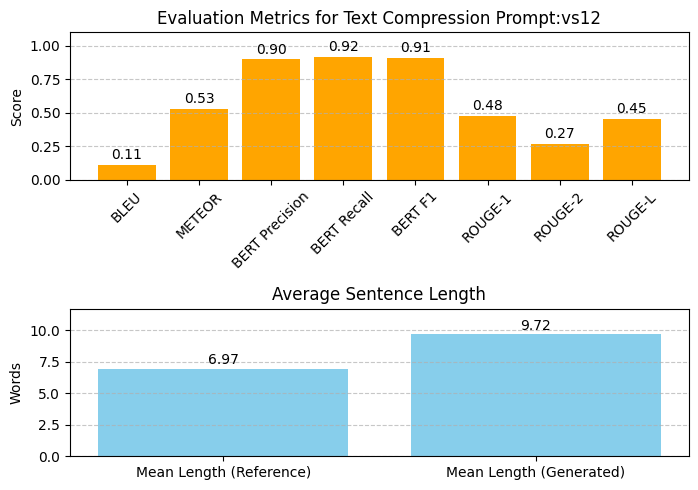

100%|██████████| 32/32 [02:29<00:00,  4.67s/it]




----------------Prompt: vs13---------------------


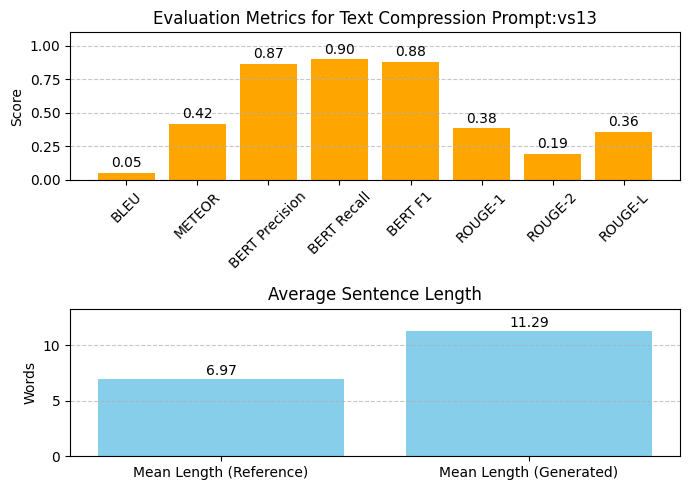

100%|██████████| 32/32 [02:08<00:00,  4.03s/it]




----------------Prompt: few_shots_basic---------------------


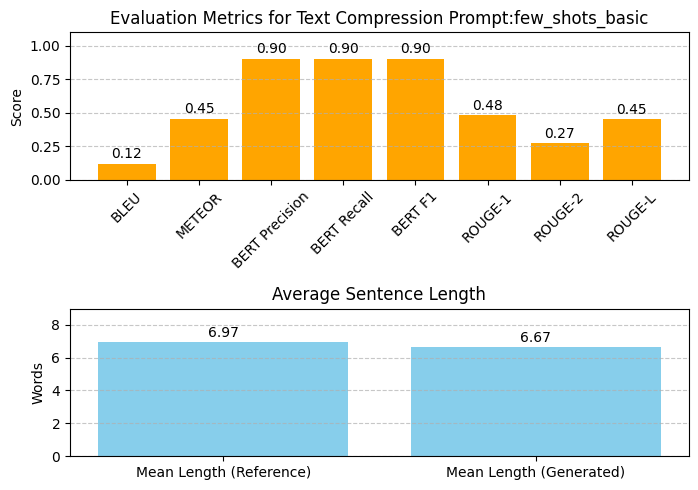

100%|██████████| 32/32 [02:43<00:00,  5.12s/it]




----------------Prompt: one_shot_vs12---------------------


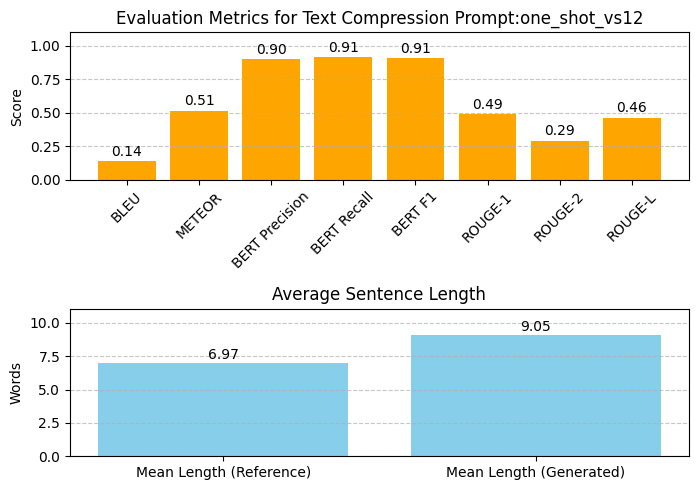

100%|██████████| 32/32 [03:02<00:00,  5.70s/it]




----------------Prompt: few_shots_vs12---------------------


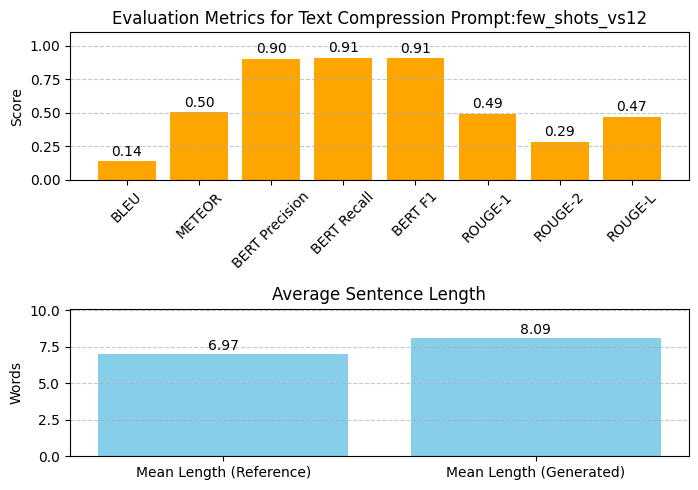

100%|██████████| 32/32 [02:19<00:00,  4.35s/it]




----------------Prompt: cot_bullet_reason---------------------


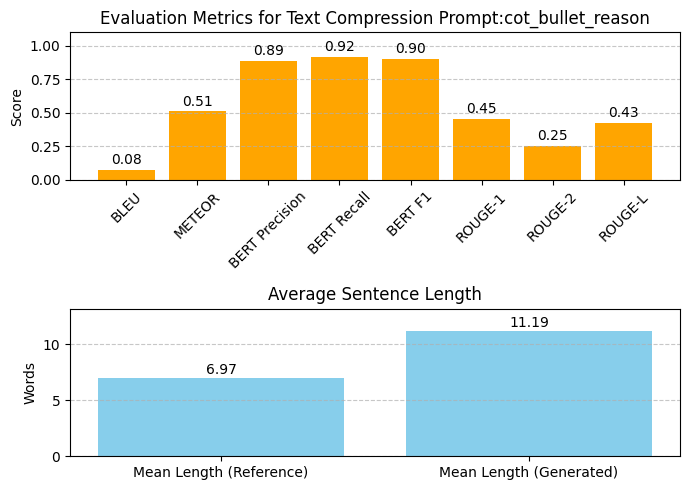

100%|██████████| 32/32 [04:40<00:00,  8.77s/it]




----------------Prompt: cot_deliberate_refine---------------------


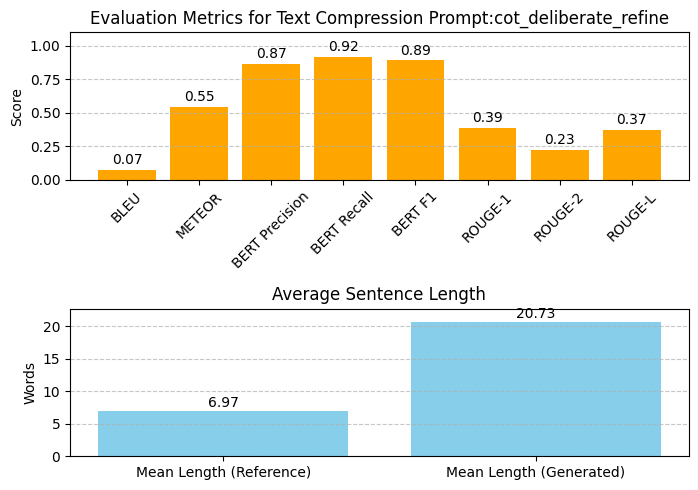

In [53]:
compressed_reference = [example['compressed'] for example in test_ds]
best_system_prompt_from_ex3 = "You are an AI assistant that prioritizes factual accuracy and conciseness above all else. Provide only the direct answer."
results_by_prompt_qwen = {}

user_prompts = {

    "vs12":"""Instruction:
      1. Identify the main person or entity who performed an action in the sentence below.
      2. Identify what significant action this person/entity performed.
      3. Identify to whom/what this action was related, if anyone/anything.
      4. Based on this, create a very short news headline.
      Output ONLY the headline.

      Sentence: {sentence}
      Headline:
      """,

    "vs13": """\
      Compress the following sentence into a short headline.
      The headline must focus on ALASTAIR Cook's achievement AND to whom it was dedicated.

      Sentence: {sentence}
      Headline:
      """,

    "few_shots_basic":
    """\
      Task: Create a very short news headline from the sentence.
      Output ONLY the headline.

      Example 1:
      Sentence: City officials have announced the annual Taste of Chicago festival will add food trucks during concerts for the first time.
      Headline: Taste of Chicago to add food trucks for concerts

      Example 2:
      Sentence: A group, the Civil Society Coalition Initiative, has said plots by the Peoples Democratic Party to cripple the Rauf Aregbesola administration in Osun State or eliminate him will fail.
      Headline: Plot against Aregbesola will fail

      Sentence: {sentence}
      Headline:
      """,

    "one_shot_vs12":
      """\
      Instruction:
      1. Identify the main person or entity who performed an action in the sentence below.
      2. Identify what significant action this person/entity performed.
      3. Identify to whom/what this action was related, if anyone/anything.
      4. Based on this, create a very short news headline.
      Output ONLY the headline.

      Example:
      Sentence: City officials have announced the annual Taste of Chicago festival will add food trucks during concerts for the first time.
      Headline: Taste of Chicago to add food trucks for concerts

      Sentence: {sentence}
      Headline:
      """,

    "few_shots_vs12":
      """\
        Instruction:
        1. Identify the main person or entity who performed an action in the sentence below.
        2. Identify what significant action this person/entity performed.
        3. Identify to whom/what this action was related, if anyone/anything.
        4. Based on this, create a very short news headline.
        Output ONLY the headline.

        Example 1:
        Sentence: City officials have announced the annual Taste of Chicago festival will add food trucks during concerts for the first time.
        Headline: Taste of Chicago to add food trucks for concerts

        Example 2:
        Sentence: A group, the Civil Society Coalition Initiative, has said plots by the Peoples Democratic Party to cripple the Rauf Aregbesola administration in Osun State or eliminate him will fail.
        Headline: Plot against Aregbesola will fail

        Sentence: {sentence}
        Headline:
        """,

    "cot_bullet_reason": """\
      Task: Create a concise news headline.

      1)First, jot down (mentally or invisibly) bullet points about who did what to whom/what.
      2)Then craft ONE short headline based on those points.
      3)Output ONLY the headline — no bullet points.

    Sentence: {sentence}
    """,

    "cot_deliberate_refine": """\
      Instruction:
      A) Draft Phase – silently draft two headline options capturing the core actor and action.
      B) Critique Phase – pick the clearer, shorter option.
      C) Output Phase – print ONLY the final headline.

      Sentence: {sentence}
      Headline:
      """

}
for prompt in user_prompts:
    generated_compressed = generate_compressed(test_ds, model, tokenizer,
                                              create_prompt_fn=create_prompt,
                                              batch_size=32,
                                              user_prompt = user_prompts[prompt],
                                              system_prompt=best_system_prompt_from_ex3)

    bleu, meteor, precision, recall, f1, rouge1, rouge2, rougeL, avg_pred, avg_ref = calculate_metrics(generated_compressed, compressed_reference)
    results_by_prompt_qwen[prompt] = {
        "generated": generated_compressed,
        "metrics": {
            "bleu": bleu,
            "meteor": meteor,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "rouge1": rouge1,
            "rouge2": rouge2,
            "rougeL": rougeL,
            "avg_pred_len": avg_pred,
            "avg_ref_len": avg_ref,
        }
    }
    print(f"\n\n----------------Prompt: {prompt}---------------------")
    visualize_metrics((bleu, meteor, precision, recall, f1, rouge1, rouge2, rougeL, avg_pred, avg_ref), prompt=prompt)

In [ ]:
# We can observe that all prompts produce longer headlines than the gold references. The highest-scoring prompts are: vs12, one_shot_vs12, and few_shots_vs12, leading to a
# consistent advantage in semantic fidelity and overall BERT scores. This suggests that structured, instruction-based prompts—especially when supported by examples—are more effective
# for sentence compression.

In [ ]:
# Now, we will look at BART model from meta and it perforamce in sentence compressions.

# Bart

In [ ]:
# BART-Large-CNN is fundamentally different from instruction-tuned chat models such as Qwen-Instruct
# Because BART’s summarization head was trained without any instruction prefix, giving it an extra leading phrase often reduces quality or adds those words directly into the summary.

In [65]:

bart_model_name = "facebook/bart-large-cnn"

bart_tokenizer = transformers.AutoTokenizer.from_pretrained(bart_model_name)

print(f"Loading model {bart_model_name}...")

bart_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(
    bart_model_name,
    device_map="auto"
)
print(f"Model {bart_model_name} successfully loaded on device: {bart_model.device}")

batch_size_bart = 32



Loading model facebook/bart-large-cnn...
Model facebook/bart-large-cnn successfully loaded on device: cuda:0


Generating with facebook/bart-large-cnn: 100%|██████████| 32/32 [00:39<00:00,  1.22s/it]


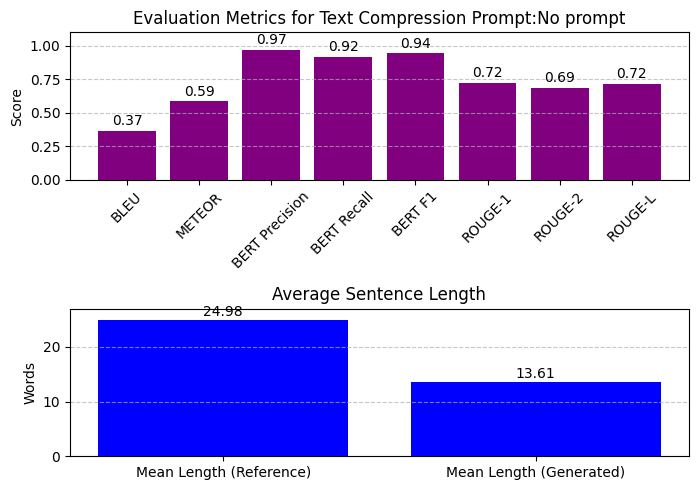

In [66]:
results_bart={}
generated_compressed_bart = []
bart_model.eval()

source_sentences_bart = [example['sentence'] for example in test_ds]

dataloader_bart = torch.utils.data.DataLoader(
    source_sentences_bart,
    batch_size=batch_size_bart
)

with torch.no_grad():
    for text_batch in tqdm.tqdm(dataloader_bart, desc=f"Generating with {bart_model_name}"):
        batch_inputs = bart_tokenizer(
            text_batch,
            max_length=1024,
            truncation=True,
            padding="longest",
            return_tensors="pt"
        ).to(bart_model.device)

        output_ids_batch = bart_model.generate(
            input_ids=batch_inputs['input_ids'],
            attention_mask=batch_inputs['attention_mask'],
            max_length=20,
            min_length=5,
            num_beams=4,
            length_penalty=1.2,
            early_stopping=True,
            no_repeat_ngram_size=3
        )

        generated_decoded_batch = bart_tokenizer.batch_decode(output_ids_batch, skip_special_tokens=True)
        generated_compressed_bart.extend(generated_decoded_batch)

bleu, meteor, prec, rec, f1, r1, r2, rL, avg_pred, avg_ref = calculate_metrics(generated_compressed_bart, source_sentences_bart)


results_bart["generated"] = generated
results_bart["metrics"] = {
      "bleu": bleu,
      "meteor": meteor,
      "precision": prec,
      "recall": rec,
      "f1": f1,
      "rouge1": r1,
      "rouge2": r2,
      "rougeL": rL,
      "avg_pred_len": avg_pred,
      "avg_ref_len": avg_ref,
  }

visualize_metrics((bleu, meteor, prec, rec, f1, r1, r2, rL, avg_pred, avg_ref), prompt='No prompt', model_name="bart")

In [ ]:
# here the reference is the original sentence

# flan

In [ ]:
import transformers, torch

model_name = "google/flan-t5-large"
tokenizer  = transformers.AutoTokenizer.from_pretrained(model_name)

model = transformers.AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16
).eval()


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:  48%|####8     | 1.51G/3.13G [00:00<?, ?B/s]

In [1]:
def create_prompt_plain(sentence: str,
                        user_prompt: str,
                        system_prompt: str) -> str:
    return f"{system_prompt.strip()}\n\n{user_prompt.format(sentence=sentence).strip()}"


In [3]:

compressed_reference = [ex["compressed"] for ex in test_ds]

results_flab = {}

for prompt_name, tmpl in user_prompts.items():
    print(f"\n\n---------------- Prompt: {prompt_name} ---------------------")

    generated_compressed = generate_compressed(
        test_ds, model, tokenizer,
        create_prompt_fn=create_prompt_plain,
        batch_size=16,
        user_prompt=tmpl,
        system_prompt=best_system_prompt_from_ex3
    )

    bleu, meteor, precision, recall, f1, rouge1, rouge2, rougeL, avg_pred, avg_ref = calculate_metrics(generated_compressed, compressed_reference)

    results_flab[prompt_name] = {
        "generated": generated_compressed,
        "metrics": {
            "bleu": bleu,
            "meteor": meteor,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "rouge1": rouge1,
            "rouge2": rouge2,
            "rougeL": rougeL,
            "avg_pred_len": avg_pred,
            "avg_ref_len": avg_ref,
        }
    }

    visualize_metrics(
        (bleu, meteor, precision, recall, f1,
         rouge1, rouge2, rougeL, avg_pred, avg_ref),
        prompt=prompt_name,
        model_name="llama3"
    )

NameError: name 'test_ds' is not defined